# Import Supporting Libraries

In [1]:
from scipy.io import wavfile
import matplotlib.pyplot as plt
import librosa
import librosa.display
from scipy import signal
from scipy.io import wavfile
import numpy as np
import IPython
import cv2
import os

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Data Collection/Exploration

In [3]:
#navigate to folder
path = os.getcwd()
os.chdir('.\\free-spoken-digit-dataset-master\\recordings')
#print(os.getcwd())

In [4]:
#wavList contains the filenames of recordings
wavList = os.listdir()
print('Avaliable Data: ' + str(len(wavList)) + ' files')

#get labels for recordings
labels = []
for file in wavList:
    labels.append(file[0])

Avaliable Data: 3000 files


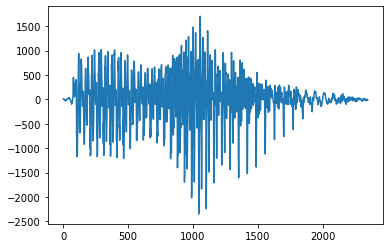

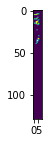

Label: 0


In [7]:
#inspect a recording from the dataset
sample_rate, samples = wavfile.read(wavList[291])
frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate, ('tukey', 0.05))
(thresh, imgBW) = cv2.threshold(spectrogram, 220, 255, cv2.THRESH_BINARY)
plt.plot(samples)
plt.show()
plt.figure(figsize=(2,2))
plt.imshow(imgBW)
plt.show()
print('Label: ' + str(labels[0]))
IPython.display.Audio(wavList[0])

# Data Preparation

In [8]:
#determine the longest recording, and index of different #s
maxLen = 0
for i in range(len(wavList)):
    sample_rate, samples = wavfile.read(wavList[i])
    if len(samples) > maxLen:
        maxLen = len(samples)
print('\nmax length: '+ str(maxLen))


max length: 18262


In [9]:
#get spectrograms from recordings
spec = []

def getSpectrogram(name):
    sample_rate, samples = wavfile.read(name)
    arr = np.zeros(maxLen)
    arr[:len(samples)] = samples[:maxLen]
    frequencies, times, spectrogram = signal.spectrogram(arr, sample_rate)
    (thresh, imgBW) = cv2.threshold(spectrogram, 100, 255, cv2.THRESH_BINARY)
    imgBW = imgBW.flatten()
    return imgBW

for i in range(len(wavList)):
    spec.append(getSpectrogram(wavList[i]))

#original shape of (129, 81)
print(len(spec))
print(spec[0].shape)

3000
(10449,)


In [10]:
#split into train and test data
arr0 = spec[0:289]
arr1 = spec[300:589]
arr2 = spec[600:889]
arr3 = spec[900:1189]
arr4 = spec[1200:1489]
arr5 = spec[1500:1789]
arr6 = spec[1800:2089]
arr7 = spec[2100:2389]
arr8 = spec[2400:2689]
arr9 = spec[2700:2989]

testArr0 = spec[290:299]
testArr1 = spec[590:599]
testArr2 = spec[890:899]
testArr3 = spec[1190:1199]
testArr4 = spec[1490:1499]
testArr5 = spec[1790:1799]
testArr6 = spec[2090:2099]
testArr7 = spec[2390:2399]
testArr8 = spec[2690:2699]
testArr9 = spec[2990:2999]

#define general array for training
arrTrain = np.array([arr0, arr1, arr2, arr3, arr4, arr5, arr6, arr7, arr8, arr9])

#define general array for testing
arrTest = np.array([testArr0, testArr1, testArr2, testArr3, testArr4, testArr5, testArr6, testArr7, testArr8, testArr9])

#calculate prior probability, each training array has 290 elements
prior = 290 / (290*10)

# Class Model Generation

0:


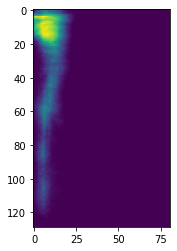

1:


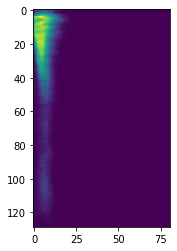

2:


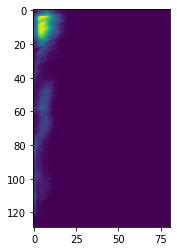

3:


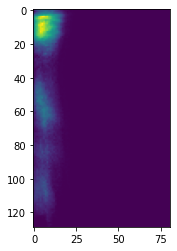

4:


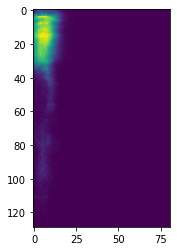

5:


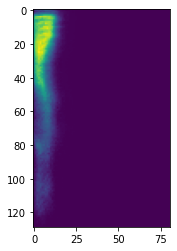

6:


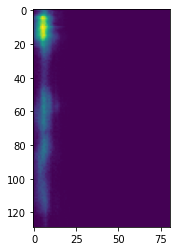

7:


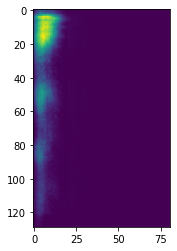

8:


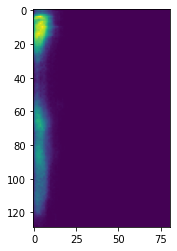

9:


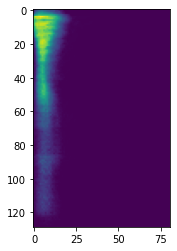

In [11]:
#input is an array containing the flattened spectrograms of each class
def getProb(arr):
    arrLoc = np.zeros(len(arr[0]))
    for i in range(len(arr)):
        for j in range(len(arr[i])):
            if arr[i][j] == 255:
                arrLoc[j] += 1 #increment by one for the appropriate pixel
    return arrLoc / len(arr)

pixelProbability = [] #contains the list of probabilities of each pixel for all classes
for k in range(len(arrTrain)):
    print(str(k) + ':')
    prob1D = getProb(arrTrain[k])
    pixelProbability.append(prob1D)
    plt.imshow(prob1D.reshape((129,81)))
    plt.show()

Text(0.5, 1.0, '9')

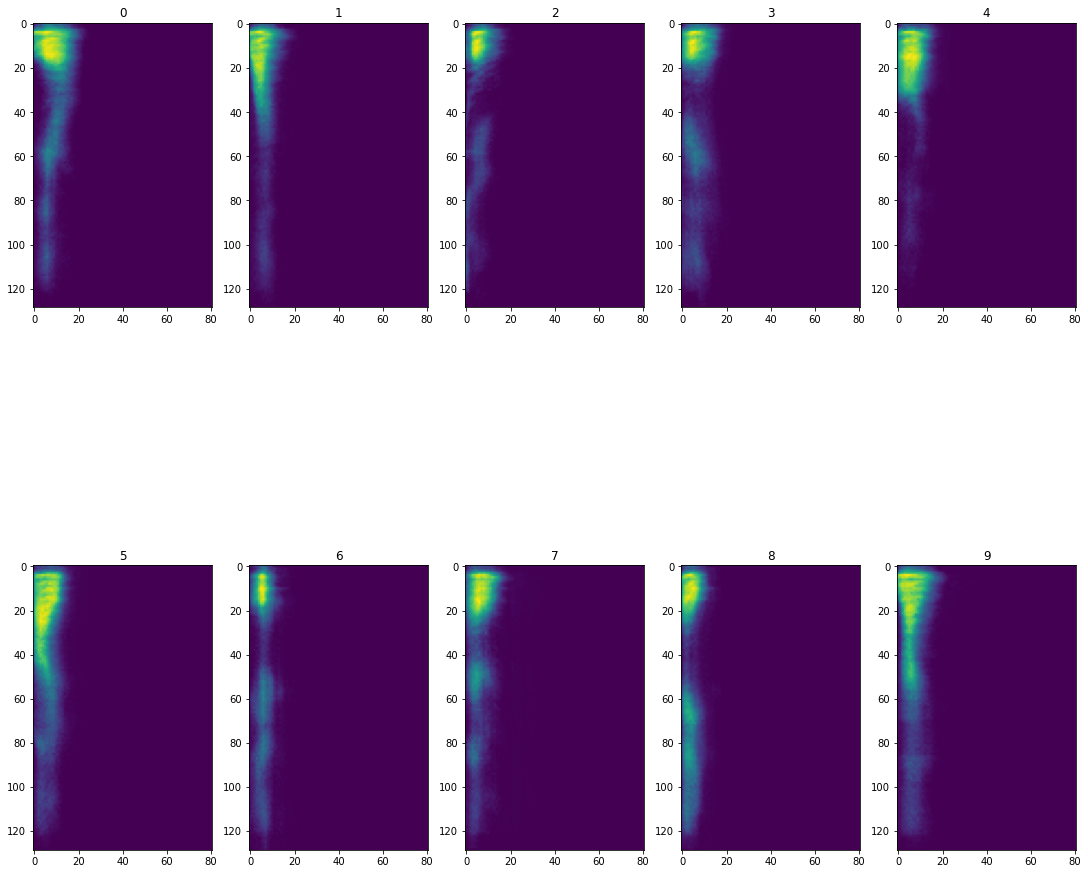

In [12]:
f, axarr = plt.subplots(2,5,figsize=(15,15),constrained_layout=True)
axarr[0,0].imshow(pixelProbability[0].reshape((129,81)))
axarr[0,0].set_title('0')
axarr[0,1].imshow(pixelProbability[1].reshape((129,81)))
axarr[0,1].set_title('1')
axarr[0,2].imshow(pixelProbability[2].reshape((129,81)))
axarr[0,2].set_title('2')
axarr[0,3].imshow(pixelProbability[3].reshape((129,81)))
axarr[0,3].set_title('3')
axarr[0,4].imshow(pixelProbability[4].reshape((129,81)))
axarr[0,4].set_title('4')
axarr[1,0].imshow(pixelProbability[5].reshape((129,81)))
axarr[1,0].set_title('5')
axarr[1,1].imshow(pixelProbability[6].reshape((129,81)))
axarr[1,1].set_title('6')
axarr[1,2].imshow(pixelProbability[7].reshape((129,81)))
axarr[1,2].set_title('7')
axarr[1,3].imshow(pixelProbability[8].reshape((129,81)))
axarr[1,3].set_title('8')
axarr[1,4].imshow(pixelProbability[9].reshape((129,81)))
axarr[1,4].set_title('9')

# Compute Training Set Accuracy

In [13]:
#predicts the audio signal's class based on the spectrograms
def predictClass(inputImg, pixelProbability):
    probabilityList = []
    
    for i in range(len(pixelProbability)):
        classifier = pixelProbability[i]
        prob = np.log(prior)
        for j in range(len(classifier)):
            inputVal = 0
            if inputImg[j] == 255:
                inputVal = 1
            if classifier[j] == 0:
                continue

            #probability calculation
            prob += (inputVal*np.log(classifier[j]) + (1-inputVal)*np.log(1-classifier[j]))
        probabilityList.append(prob)
    #print(probabilityList)
    #print('Prediction: ' + str(np.argmax(probabilityList)))
    return np.argmax(probabilityList)

In [14]:
#computes the accuracy for classification of a certain digit
def computeAccuracy(inputClass, label):
    correct = 0
    total = 0
    for spec in inputClass:
        if predictClass(spec, pixelProbability) == label:
            correct += 1
        total += 1
    print(round((correct/total) * 100, 3))
    return correct, total

In [15]:
#computing accuracy of each training set (%)
overallCorrectTrain = 0
overallTotalTrain = 0

for i in range(len(arrTrain)):
    (cor, tot) = computeAccuracy(arrTrain[i], i)
    overallCorrectTrain += cor
    overallTotalTrain += tot

50.173
47.059
69.55
2.768
56.747
37.37
55.017
21.107
57.785
49.135


In [16]:
#compute overall accuracy across all training data (%)
print(round((overallCorrectTrain/overallTotalTrain) * 100, 3))

44.671


# Compute Testing Set Accuracy

In [17]:
#computing accuracy of each testing set (%)
overallCorrectTest = 0
overallTotalTest = 0

for i in range(len(arrTest)):
    (cor, tot) = computeAccuracy(arrTest[i], i)
    overallCorrectTest += cor
    overallTotalTest += tot

0.0
55.556
100.0
0.0
77.778
0.0
88.889
11.111
11.111
0.0


In [18]:
#compute overall accuracy across all training data (%)
print(round((overallCorrectTest/overallTotalTest) * 100, 3))

34.444
